In [1]:
import pickle
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

import con_score

Filter data on players with > 10 games

In [2]:
df = pd.read_csv('../output/Chess.com/final_df.csv')
stats = pd.read_csv("../output/Chess.com/player_stats.csv")

In [3]:
min_games = 10
frequent_players = stats[stats.total_games > min_games].username.unique()
df = df[df.white_username.isin(frequent_players) & df.black_username.isin(frequent_players)]

In [4]:
#df = df[df.white_username != 'benny_aizenberg']
#df = df[df.black_username != 'benny_aizenberg']

In [5]:
df.year.value_counts()

year
2024    19024
2023    16482
Name: count, dtype: int64

In [6]:
df = df[df.year == 2024]

In [7]:
df.to_csv('../output/Chess.com/final_df_min10.csv', index=False)

Create Digraph

In [8]:
G = nx.DiGraph()
for _, row in df.iterrows():
    white_player = row['white_username']
    black_player = row['black_username']
    if row['white_result'] == '1':
        if G.has_edge(white_player, black_player):
            G[white_player][black_player]['weight'] += 1
        else:
            G.add_edge(white_player, black_player, weight=1)
    if row['black_result'] == '1':
        if G.has_edge(black_player, white_player):
            G[black_player][white_player]['weight'] += 1
        else:
            G.add_edge(black_player, white_player, weight=1)
    if row['white_result'] == '½':
        if G.has_edge(black_player, white_player):
            G[black_player][white_player]['weight'] += 0.5
        if G.has_edge(white_player, black_player):
            G[white_player][black_player]['weight'] += 0.5
        elif not G.has_edge(black_player, white_player):
            G.add_edge(black_player, white_player, weight=0.5)
        elif not G.has_edge(white_player, black_player):
            G.add_edge(white_player, black_player, weight=0.5)

In [9]:
G.number_of_nodes(), G.number_of_edges()

(863, 15881)

Check sparsity of G

In [10]:
n = G.number_of_nodes()
m = G.number_of_edges()
sparsity = m / (n * (n - 1))
sparsity

0.02134812731716104

In [11]:
G_undirected = G.to_undirected()
nx.is_connected(G_undirected)

True

In [12]:
print(nx.number_weakly_connected_components(G))
print(nx.number_strongly_connected_components(G))

1
152


In [13]:
max_diameter = 0
for component in nx.weakly_connected_components(G):
    subgraph = G.subgraph(component)
    undirected_subgraph = subgraph.to_undirected()
    diameter = nx.diameter(undirected_subgraph)
    max_diameter = max(max_diameter, diameter)
print(f"Maximum Diameter of Weakly Connected Components (Undirected): {max_diameter}")

Maximum Diameter of Weakly Connected Components (Undirected): 4


In [14]:
df = df[df['white_elo'].notna()]
df = df[df['black_elo'].notna()]

df = df[df['white_elo']!='Unrated']
df = df[df['black_elo']!='Unrated']

df['white_elo'] = df['white_elo'].astype(int)
df['black_elo'] = df['black_elo'].astype(int)

### Calculate CON and PageRank

In [15]:
try: 
    elo_dict = pd.read_pickle('../output/Chess.com/elo_dict.pkl')
except:
    elo_dict = {}
    for index, row in df.iterrows():
        elo_dict[row['white_username']] = row['white_elo']
    for index, row in df.iterrows():
        elo_dict[row['black_username']] = row['black_elo']
    with open('../output/Chess.com/elo_dict.pkl', 'wb') as f:
        pickle.dump(elo_dict, f)

In [16]:
try: 
    CON_score = pd.read_pickle('../output/Chess.com/CON_score_dict.pkl')
except:
    CON_score = con_score.compute_con_scores(G)
    with open('../output/Chess.com/CON_score_dict.pkl', 'wb') as f:
        pickle.dump(CON_score, f)

In [17]:
pagerank = nx.pagerank(G, weight='weight')

In [18]:
rank_data = []
for player in CON_score.keys():
    rank_data.append({'Player Name': player, 
                      'CON Score': CON_score[player], 
                      'PageRank': pagerank.get(player, 0), 
                      'Elo': elo_dict.get(player, 0)})
rank_df = pd.DataFrame(rank_data)

Normalize rankings

In [19]:
rank_df['Elo'] = rank_df['Elo'].astype(int)

In [20]:
rank_df['CON Score'] = (rank_df['CON Score'] - rank_df['CON Score'].min()) / (rank_df['CON Score'].max() - rank_df['CON Score'].min())
rank_df['PageRank'] = (rank_df['PageRank'] - rank_df['PageRank'].min()) / (rank_df['PageRank'].max() - rank_df['PageRank'].min())
rank_df['Elo'] = (rank_df['Elo'] - rank_df['Elo'].min()) / (rank_df['Elo'].max() - rank_df['Elo'].min())

In [21]:
rank_df.to_csv('../output/Chess.com/player_rankings.csv', index=False)

Compute centrality measures for test statistic

In [22]:
out_degree_centrality = dict(G.out_degree(weight='weight'))
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, weight='weight', normalized=True)

centrality_df = pd.DataFrame({
    'Player': list(G.nodes),
    'Out-Degree Centrality': [out_degree_centrality.get(player, 0) for player in G.nodes],
    'Closeness Centrality': [closeness_centrality.get(player, 0) for player in G.nodes],
    'Betweenness Centrality': [betweenness_centrality.get(player, 0) for player in G.nodes],
    'CON Score': [CON_score.get(player, 0) for player in G.nodes]
})

centrality_df['Elo'] = centrality_df['Player'].map(elo_dict).astype(float)

G_inverted = G.reverse(copy=True)
pagerank_centrality = nx.pagerank(G_inverted, weight='weight')
centrality_df['PageRank Centrality'] = [pagerank_centrality.get(player, 0) for player in centrality_df['Player']]

Normalize centralities

In [23]:
for col in ['Out-Degree Centrality', 'Closeness Centrality', 'Betweenness Centrality', 'PageRank Centrality', 'CON Score', 'Elo']:
    centrality_df[col] = (centrality_df[col] - centrality_df[col].min()) / (centrality_df[col].max() - centrality_df[col].min())

Plot centrality for top players

In [24]:
centrality_df.Player.nunique()

863

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


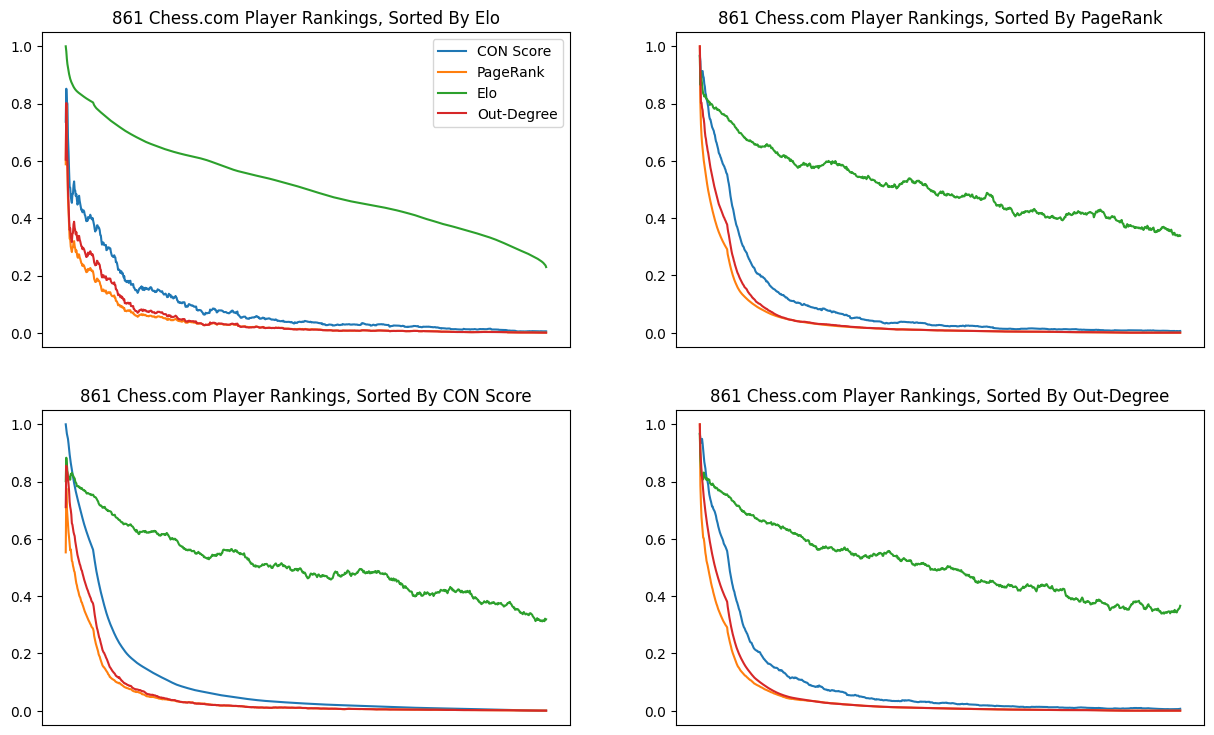

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(15, 9))
window_size = 50

def smooth_series(data, window):
    return data.rolling(window=window, min_periods=1).mean()

rank_df_small = centrality_df.sort_values('Elo', ascending=False)
axs[0, 0].plot(rank_df_small['Player'], smooth_series(rank_df_small['CON Score'], window_size), label='CON Score')
axs[0, 0].plot(rank_df_small['Player'], smooth_series(rank_df_small['PageRank Centrality'], window_size), label='PageRank')
axs[0, 0].plot(rank_df_small['Player'], smooth_series(rank_df_small['Elo'], window_size), label='Elo')
axs[0, 0].plot(rank_df_small['Player'], smooth_series(rank_df_small['Out-Degree Centrality'], window_size), label='Out-Degree')
axs[0, 0].set_title('861 Chess.com Player Rankings, Sorted By Elo')
axs[0, 0].legend()
axs[0, 0].set_xticks([])

rank_df_small = centrality_df.sort_values('PageRank Centrality', ascending=False)
axs[0, 1].plot(rank_df_small['Player'], smooth_series(rank_df_small['CON Score'], window_size), label='CON Score')
axs[0, 1].plot(rank_df_small['Player'], smooth_series(rank_df_small['PageRank Centrality'], window_size), label='PageRank')
axs[0, 1].plot(rank_df_small['Player'], smooth_series(rank_df_small['Elo'], window_size), label='Elo')
axs[0, 1].plot(rank_df_small['Player'], smooth_series(rank_df_small['Out-Degree Centrality'], window_size), label='Out-Degree')
axs[0, 1].set_title('861 Chess.com Player Rankings, Sorted By PageRank')
axs[0, 1].set_xticks([])

rank_df_small = centrality_df.sort_values('CON Score', ascending=False)
axs[1, 0].plot(rank_df_small['Player'], smooth_series(rank_df_small['CON Score'], window_size), label='CON Score')
axs[1, 0].plot(rank_df_small['Player'], smooth_series(rank_df_small['PageRank Centrality'], window_size), label='PageRank')
axs[1, 0].plot(rank_df_small['Player'], smooth_series(rank_df_small['Elo'], window_size), label='Elo')
axs[1, 0].plot(rank_df_small['Player'], smooth_series(rank_df_small['Out-Degree Centrality'], window_size), label='Out-Degree')
axs[1, 0].set_title('861 Chess.com Player Rankings, Sorted By CON Score')
axs[1, 0].set_xticks([])

rank_df_small = centrality_df.sort_values('Out-Degree Centrality', ascending=False)
axs[1, 1].plot(rank_df_small['Player'], smooth_series(rank_df_small['CON Score'], window_size), label='CON Score')
axs[1, 1].plot(rank_df_small['Player'], smooth_series(rank_df_small['PageRank Centrality'], window_size), label='PageRank')
axs[1, 1].plot(rank_df_small['Player'], smooth_series(rank_df_small['Elo'], window_size), label='Elo')
axs[1, 1].plot(rank_df_small['Player'], smooth_series(rank_df_small['Out-Degree Centrality'], window_size), label='Out-Degree')
axs[1, 1].set_title('861 Chess.com Player Rankings, Sorted By Out-Degree')
axs[1, 1].set_xticks([])

plt.savefig('../output/Chess.com/centrality_measures_MA_2x2_plot.eps', format='eps')
plt.show()

Create table for Spearman correlations

In [26]:
spearman_out_degree = spearmanr(centrality_df['Elo'], centrality_df['Out-Degree Centrality'], nan_policy='omit')
spearman_closeness = spearmanr(centrality_df['Elo'], centrality_df['Closeness Centrality'], nan_policy='omit')
spearman_betweenness = spearmanr(centrality_df['Elo'], centrality_df['Betweenness Centrality'], nan_policy='omit')
spearman_pagerank = spearmanr(centrality_df['Elo'], centrality_df['PageRank Centrality'], nan_policy='omit')
spearman_conscore = spearmanr(centrality_df['Elo'], centrality_df['CON Score'], nan_policy='omit')

results = {
    'Centrality Metric': [
        'Out-Degree Centrality',
        'Closeness Centrality',
        'Betweenness Centrality',
        'PageRank Centrality',
        'CON Score'
    ],
    'Spearmans R Statistic': [
        spearman_out_degree.correlation,
        spearman_closeness.correlation,
        spearman_betweenness.correlation,
        spearman_pagerank.correlation,
        spearman_conscore.correlation
    ],
    'P-Value': [
        spearman_out_degree.pvalue,
        spearman_closeness.pvalue,
        spearman_betweenness.pvalue,
        spearman_pagerank.pvalue,
        spearman_conscore.pvalue
    ]
}

spearman_df = pd.DataFrame(results)
spearman_df.sort_values('Spearmans R Statistic', ascending=False)

,Centrality Metric,Spearmans R Statistic,P-Value
0,Out-Degree Centrality,0.739061,6.929134e-150
3,PageRank Centrality,0.711285,5.740657e-134
4,CON Score,0.707234,8.381500e-132
2,Betweenness Centrality,0.669015,4.519517e-113
1,Closeness Centrality,0.340305,7.711550e-25


In [27]:
spearman_df.to_csv('../output/Chess.com/Chess_spearman_correlations_table.csv', index=False)